<a href="https://colab.research.google.com/github/BrunoBVR/DL-with-python/blob/main/2ndEd_8p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a convnet from scratch on a small dataset

Cats vs. Dogs

In [2]:
import os, shutil, pathlib

original_dir = pathlib.Path("/content/drive/MyDrive/DL-With-Python/Chapter8-2ndEd/train/train")
new_base_dir = pathlib.Path("/content/drive/MyDrive/DL-With-Python/Chapter8-2ndEd/cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg"
              for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src=original_dir / fname,
                      dst=dir / fname)


In [3]:

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

## Instantiating a small convnet for dogs vs. cats classification

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

# Model will expect RGB images of size 180 x 180
inputs = keras.Input(shape=(180,180,3))

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 41, 41, 128)       7385

## Configuring the model for training

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Data processing

In [17]:
from tensorflow.keras.utils import image_dataset_from_directory

In [18]:
train_dataset = image_dataset_from_directory(
  new_base_dir / "train",
  image_size=(180, 180),
  batch_size=32)
validation_dataset = image_dataset_from_directory(
  new_base_dir / "validation",
  image_size=(180, 180),
  batch_size=32)
test_dataset = image_dataset_from_directory(
  new_base_dir / "test",
  image_size=(180, 180),
  batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Let’s look at the output of one of these Dataset objects: it yields batches of 180 × 180 RGB images (shape (32, 180, 180, 3) ) and integer labels (shape (32,) ). There are 32 samples in each batch (the batch size).

In [19]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## Fitting the model using a Dataset (with callbacks)

In [20]:
callbacks = [
             keras.callbacks.ModelCheckpoint(
                 filepath="/content/drive/MyDrive/DL-With-Python/Chapter8-2ndEd/convnet_from_scratch.keras",
                 save_best_only=True,
                 monitor='val_loss'
             )
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/30
63/63 [==============================] - 11s 155ms/step - loss: 0.7599 - accuracy: 0.5135 - val_loss: 0.6910 - val_accuracy: 0.5140
Epoch 2/30
63/63 [==============================] - 10s 150ms/step - loss: 0.7163 - accuracy: 0.5315 - val_loss: 0.6863 - val_accuracy: 0.5990
Epoch 3/30
63/63 [==============================] - 10s 149ms/step - loss: 0.7116 - accuracy: 0.5770 - val_loss: 0.6837 - val_accuracy: 0.5320
Epoch 4/30
63/63 [==============================] - 11s 160ms/step - loss: 0.6680 - accuracy: 0.6220 - val_loss: 0.6002 - val_accuracy: 0.6780
Epoch 5/30
63/63 [==============================] - 10s 153ms/step - loss: 0.6182 - accuracy: 0.6615 - val_loss: 0.6151 - val_accuracy: 0.6390
Epoch 6/30
63/63 [==============================] - 10s 151ms/step - loss: 0.5867 - accuracy: 0.7065 - val_loss: 0.6713 - val_accuracy: 0.6010
Epoch 7/30
63/63 [==============================] - 10s 150ms/step - loss: 0.5407 - accuracy: 0.7290 - val_loss: 0.6672 - val_accuracy: 0.6020

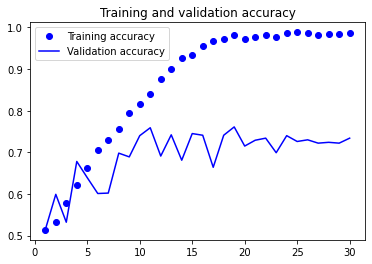

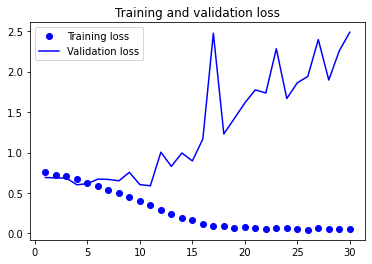

In [21]:
# Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [22]:
test_model = keras.models.load_model("/content/drive/MyDrive/DL-With-Python/Chapter8-2ndEd/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 88ms/step - loss: 0.6562 - accuracy: 0.7350
Test accuracy: 0.735


## Using data augmentation

In [23]:
# Define a data augmentation stage to add to an image model
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)

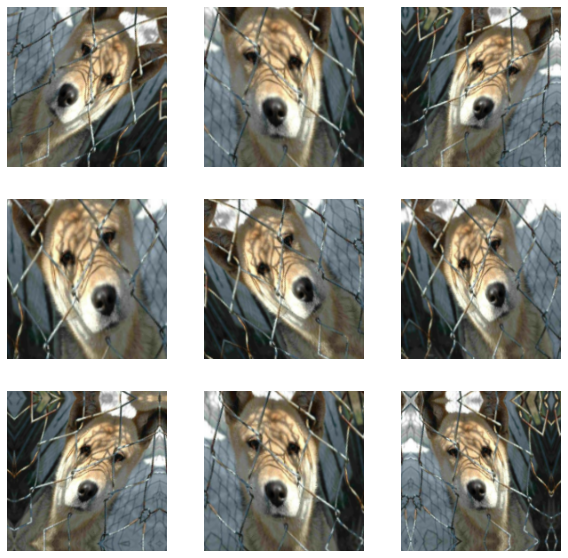

In [25]:
# Displaying some randomly augmented training images
plt.figure(figsize=(10, 10))

for images, _ in train_dataset.take(1):
  for i in range(9):
    # Apply data augmentation stage to the batch of images
    augmented_images = data_augmentation(images)

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Defining a new convnet that includes image augmentation and dropout

In [26]:
inputs = keras.Input(shape=(180, 180, 3))

x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [27]:
# Training
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/DL-With-Python/Chapter8-2ndEd/convnet_from_scratch_with_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 13s 161ms/step - loss: 0.7142 - accuracy: 0.5080 - val_loss: 0.6898 - val_accuracy: 0.6140
Epoch 2/100
63/63 [==============================] - 10s 155ms/step - loss: 0.7038 - accuracy: 0.5425 - val_loss: 0.8689 - val_accuracy: 0.5070
Epoch 3/100
63/63 [==============================] - 10s 154ms/step - loss: 0.6883 - accuracy: 0.6000 - val_loss: 0.7066 - val_accuracy: 0.6040
Epoch 4/100
63/63 [==============================] - 10s 155ms/step - loss: 0.6651 - accuracy: 0.6190 - val_loss: 0.6485 - val_accuracy: 0.6100
Epoch 5/100
63/63 [==============================] - 10s 153ms/step - loss: 0.6176 - accuracy: 0.6690 - val_loss: 1.2480 - val_accuracy: 0.5940
Epoch 6/100
63/63 [==============================] - 10s 153ms/step - loss: 0.6262 - accuracy: 0.6570 - val_loss: 0.6010 - val_accuracy: 0.6760
Epoch 7/100
63/63 [==============================] - 10s 155ms/step - loss: 0.6203 - accuracy: 0.6695 - val_loss: 0.6214 - val_accuracy:

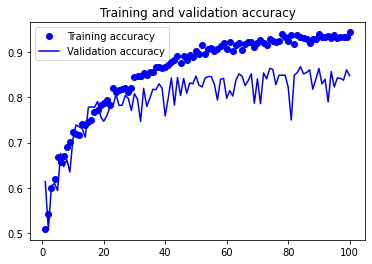

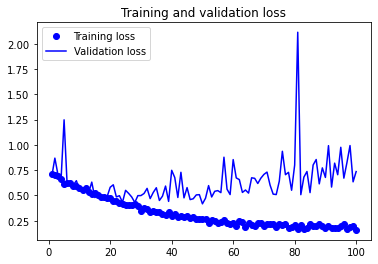

In [28]:
# Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [30]:
# Evaluating test set
test_model = keras.models.load_model(
    "/content/drive/MyDrive/DL-With-Python/Chapter8-2ndEd/convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 88ms/step - loss: 0.4546 - accuracy: 0.8355
Test accuracy: 0.836
